In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import os

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [11]:
species_features_paths = {"binary": "../../data/features/plant/binary/features_by_network",
                         "weighted": "../../data/features/plant/weighted/features_by_network/",
                         "binarized_weighted": "../../data/features/plant/binarized_weighted/features_by_network/"}

species_features_output_paths = {"binary": "../../data/features/plant/binary/features_with_classification.csv",
                         "weighted": "../../data/features/plant/weighted/features_with_classification.csv",
                         "binarized_weighted": "../../data/features/plant/binarized_weighted/features_with_classification.csv"}

network_features_dirs = {"binary": "../../data/features/network/binary/features_by_network/",
                         "weighted": "../../data/features/network/weighted/features_by_network/",
                         "binarized_weighted": "../../data/features/network/binarized_weighted/features_by_network/"}

network_features_output_paths = {"binary": "../../data/features/network/binary/features_with_classification.csv",
                         "weighted": "../../data/features/network/weighted/features_with_classification.csv",
                         "binarized_weighted": "../../data/features/network/binarized_weighted/features_with_classification.csv"}

features_of_interest = {"plant": ["partner.diversity", "d", "normalised.degree", "weighted.betweenness", "weighted.closeness"],
                        "network": ["connectance", "NODF", "modularity"]}

species_features_dir = "../../data/features/plant/"
network_features_dir = "../../data/features/network/"

network_classification_path = f"../../data/ploidy_classification/network_classification.csv"

# standarize species features using the ranking approach of Stouffer et al. 2014

In [3]:
alternative_features_df = []
for network_type in species_features_output_paths:
    features_dir = f"{species_features_dir}{network_type}/"
    if os.path.exists(species_features_output_paths[network_type]):
        features_df = pd.read_csv(species_features_output_paths[network_type])
        features_df["network_type"] = network_type
        alternative_features_df.append(features_df)
    else:
        altenative_paths = {int(p.replace("_features.csv", "")): f"{features_dir}{p}" for p in os.listdir(features_dir) if p.endswith("_features.csv")}
        for p in altenative_paths:
            df = pd.read_csv(altenative_paths[p]).rename(columns={"Unnamed: 0": "Plant"})
            df["network_id"] = int(p)
            df["network_type"] = network_type
            alternative_features_df.append(df)
alternative_features_df = pd.concat(alternative_features_df)
alternative_features_df = alternative_features_df[[c for c in alternative_features_df.columns if not c.startswith("standardized_ ")]]

In [4]:
def get_ranked_features_df(df: pd.DataFrame) -> pd.DataFrame:
    if df.shape[0] == 0:
        return df
    features = [c for c in df.columns if not c.startswith("standardized_") and c not in ["Plant", "network", "network_id", "network_type"]]
    
    for feature in features:
        df[f"standardized_{feature}"] = df[feature].rank()
        max_rank = df[f"standardized_{feature}"].max()
        df[f"standardized_{feature}"] = df[f"standardized_{feature}"] / max_rank
    
    return df

alternative_features_df = alternative_features_df.groupby(["network_type", "network_id"]).parallel_apply(lambda df: get_ranked_features_df(df))

In [5]:
standardized_features = [c for c in alternative_features_df.columns if c.startswith("standarized")]
for f in standardized_features:
    assert(alternative_features_df[f].max() <= 1)
    assert(alternative_features_df[f].max() >= 1)

In [6]:
alternative_features_df.reset_index(inplace=True, drop=True)

In [7]:
for network_type in species_features_output_paths:
    alternative_features_df.query(f"network_type == '{network_type}'").to_csv(species_features_output_paths[network_type])

In [8]:
alternative_features_df = pd.concat([pd.read_csv(species_features_output_paths[network_type]) for network_type in species_features_output_paths])

In [9]:
test = alternative_features_df.query("network_type == 'binary' and network_id == 1")[["Plant", "degree","normalised.degree", "standardized_degree", "standardized_normalised.degree"]].sort_values("degree")

features = ['partner.diversity', 'normalised.degree', 'd', 'weighted.closeness', 'weighted.betweenness']


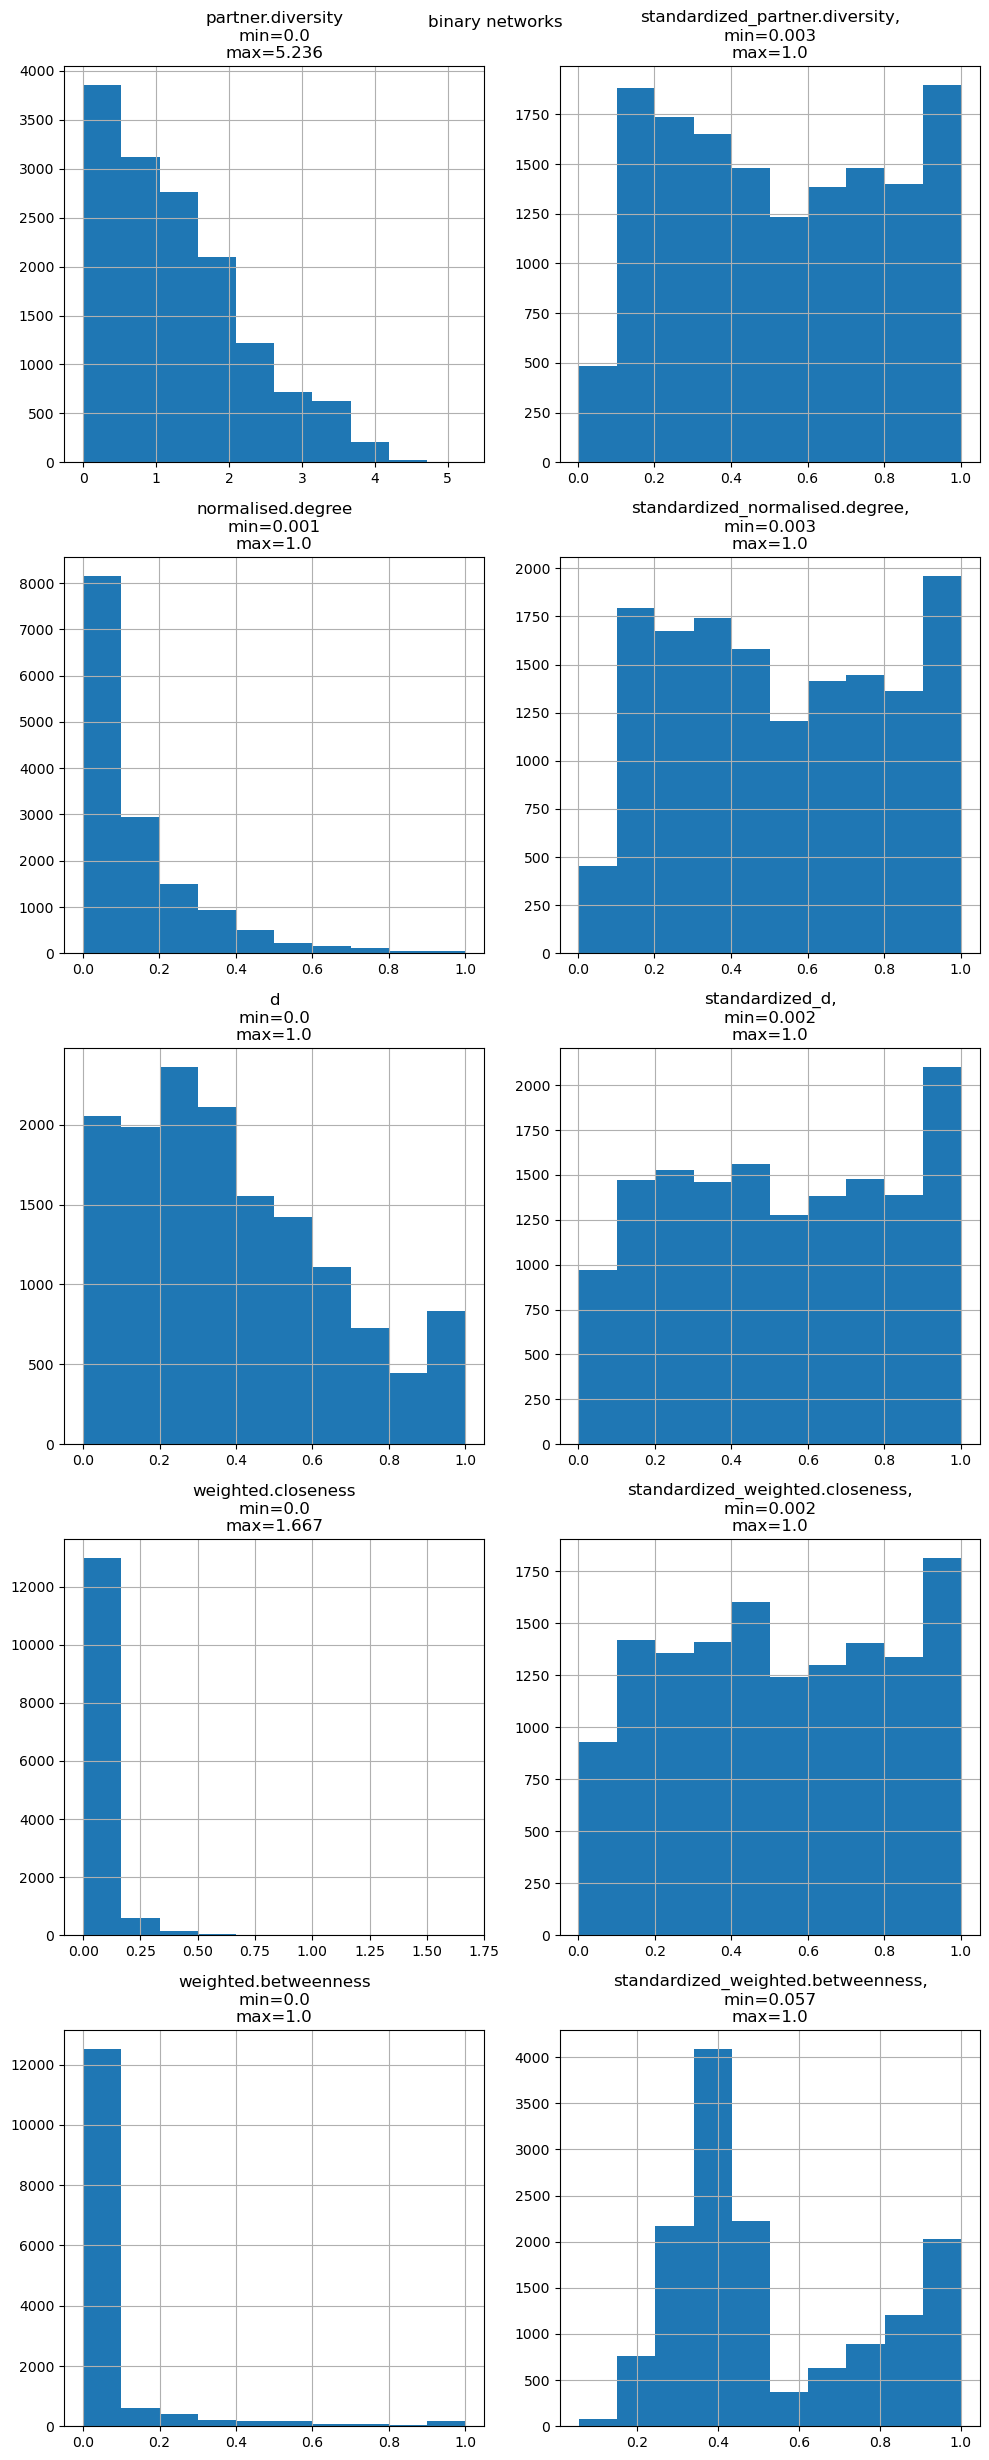

In [10]:
import matplotlib.pyplot as plt
features_to_examine = list(set(features_of_interest["plant"])&set(alternative_features_df.columns))
print(f"features = {features_to_examine}")

relevant_features = alternative_features_df.loc[alternative_features_df.network_type.str.startswith("binar")]
fig, axes = plt.subplots(nrows=len(features_to_examine), ncols=2, figsize=(10, 5*len(features_to_examine)))
fig.suptitle(f"binary networks")
for i in range(len(features_to_examine)):
    f = features_to_examine[i]
    relevant_features[f].hist(ax=axes[i][0])
    axes[i][0].set_title(f"{f}\nmin={np.round(relevant_features[f].min(),3)}\nmax={np.round(relevant_features[f].max(),3)}")
    if f"standardized_{f}" in relevant_features.columns:
        relevant_features[f"standardized_{f}"].hist(ax=axes[i][1])
        axes[i][1].set_title(f"standardized_{f},\nmin={np.round(relevant_features[f'standardized_{f}'].min(),3)}\nmax={np.round(relevant_features[f'standardized_{f}'].max(),3)}")
fig.tight_layout()
fig.savefig(f"{species_features_dir}/binary_networks_based_feature_distribution.jpeg")

features = ['partner.diversity', 'normalised.degree', 'd', 'weighted.closeness', 'weighted.betweenness']


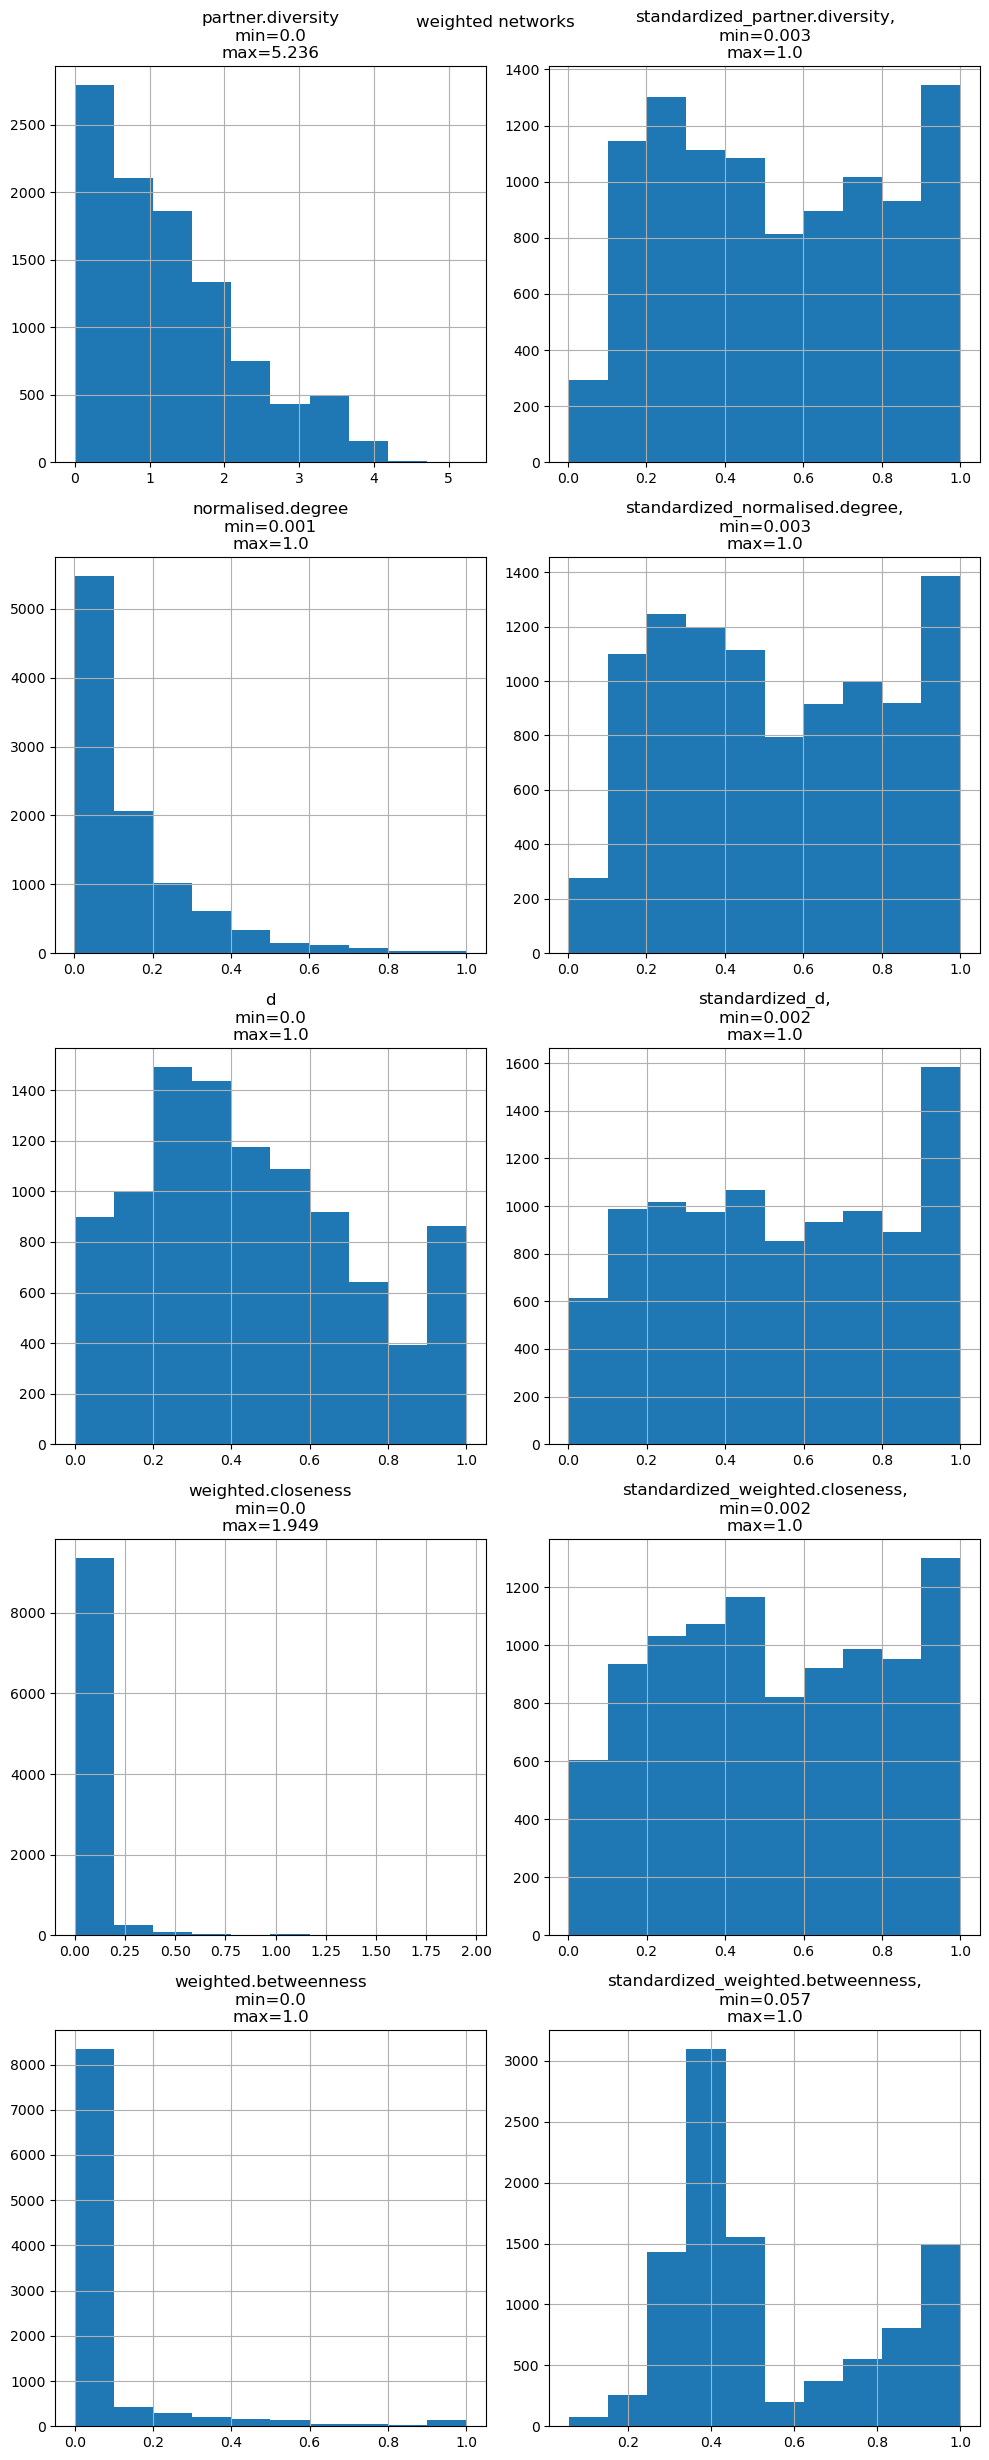

In [11]:
import matplotlib.pyplot as plt
features_to_examine = list(set(features_of_interest["plant"])&set(alternative_features_df.columns))
print(f"features = {features_to_examine}")

relevant_features = alternative_features_df.loc[alternative_features_df.network_type.str.startswith("weighted")]
fig, axes = plt.subplots(nrows=len(features_to_examine), ncols=2, figsize=(10, 5*len(features_to_examine)))
fig.suptitle(f"weighted networks")
for i in range(len(features_to_examine)):
    f = features_to_examine[i]
    relevant_features[f].hist(ax=axes[i][0])
    axes[i][0].set_title(f"{f}\nmin={np.round(relevant_features[f].min(),3)}\nmax={np.round(relevant_features[f].max(),3)}")
    if f"standardized_{f}" in relevant_features.columns:
        relevant_features[f"standardized_{f}"].hist(ax=axes[i][1])
        axes[i][1].set_title(f"standardized_{f},\nmin={np.round(relevant_features[f'standardized_{f}'].min(),3)}\nmax={np.round(relevant_features[f'standardized_{f}'].max(),3)}")
fig.tight_layout()
fig.savefig(f"{species_features_dir}/weighted_networks_based_feature_distribution.jpeg")

# standarize network features using delta transformation 

In [10]:
def get_standardized_feature(feature, network_id, network_type, alt_val, null_vals):
    if len(null_vals) == 0:
        # print(f"no null values available for feature {feature} in {network_type} network {network_id}")
        return np.nan
    return (alt_val-np.mean(null_vals))
    # all_vals = pd.Series([alt_val] + list(null_vals)).dropna()
    # return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
    
def add_standardized_features(altenative_features_path: str, null_features_path: str, network_type:str) -> pd.DataFrame:
    alt_db = pd.read_csv(altenative_features_path)
    alt_db = alt_db[[c for c in alt_db.columns if not c.startswith("delta_transformed_ ") and not c.startswith("null_standardized") and not "Unnamed" in c and not c.startswith("normalised") and not c.endswith("rank")]]
    null_db = pd.read_csv(null_features_path)
    features = (set(alt_db.columns) &  set(null_db.columns)) - {"network_id", "network_type", "network"}
    for f in features:
        alt_db[f"null_standardized_{f}"] = alt_db.apply(lambda rec: get_standardized_feature(feature=f,
                                                                                            network_id=rec.network,
                                                                                            network_type=network_type,
                                                                                            alt_val=rec[f],
                                                                                            null_vals=null_db[f].dropna().values), axis=1)
    alt_db.to_csv(altenative_features_path)
    return alt_db

In [16]:
# unite features
classification_df = pd.read_csv(network_classification_path)
for network_type in network_features_dirs:
    features_dir = network_features_dirs[network_type]
    altenative_paths = {int(p.replace("_features.csv", "")): f"{features_dir}{p}" for p in os.listdir(features_dir) if p.endswith("_features.csv")}
    altenative_paths_df = pd.DataFrame.from_dict(altenative_paths, orient="index").rename(columns={0: "alternative_path"})
    null_paths = {int(p.replace("_features_across_null_networks.csv", "")): f"{features_dir}{p}" for p in os.listdir(features_dir) if p.endswith("_features_across_null_networks.csv")}
    null_paths_df = pd.DataFrame.from_dict(null_paths, orient="index").rename(columns={0: "null_path"})
    paths_df = altenative_paths_df.join(null_paths_df, how="inner").reset_index().rename(columns={"index": "network_id"})
    print(f"network type = {network_type}, # networks = {len(altenative_paths.keys()):,}")
    paths_df["res"] = paths_df.parallel_apply(lambda rec: add_standardized_features(altenative_features_path=rec.alternative_path,
                                                                                         null_features_path=rec.null_path,
                                                                                               network_type=network_type), axis=1)
    features = pd.concat([pd.read_csv(alt_path) for alt_path in paths_df.alternative_path])
    features["network_id"] = features.network.str.replace(".csv", "").astype(int)
    # add classification
    relevant_classification_data = classification_df.query(f"network_type == '{network_type}'").drop(["network_type"], axis=1)
    features = features.merge(relevant_classification_data, on="network_id", how="left")
    features["network_type"] = network_type
    features.to_csv(network_features_output_paths[network_type])

network type = binary, # networks = 178


/tmp/ipykernel_40580/2262497818.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  features["network_id"] = features.network.str.replace(".csv", "").astype(int)
/tmp/ipykernel_40580/2262497818.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features["network_id"] = features.network.str.replace(".csv", "").astype(int)


network type = weighted, # networks = 704


/tmp/ipykernel_40580/2262497818.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  features["network_id"] = features.network.str.replace(".csv", "").astype(int)
/tmp/ipykernel_40580/2262497818.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features["network_id"] = features.network.str.replace(".csv", "").astype(int)


network type = binarized_weighted, # networks = 708


/tmp/ipykernel_40580/2262497818.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  features["network_id"] = features.network.str.replace(".csv", "").astype(int)
/tmp/ipykernel_40580/2262497818.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features["network_id"] = features.network.str.replace(".csv", "").astype(int)


In [17]:
alternative_features_df = pd.concat([pd.read_csv(network_features_output_paths[nt]) for nt in network_features_dirs])

features = ['modularity', 'NODF', 'connectance']


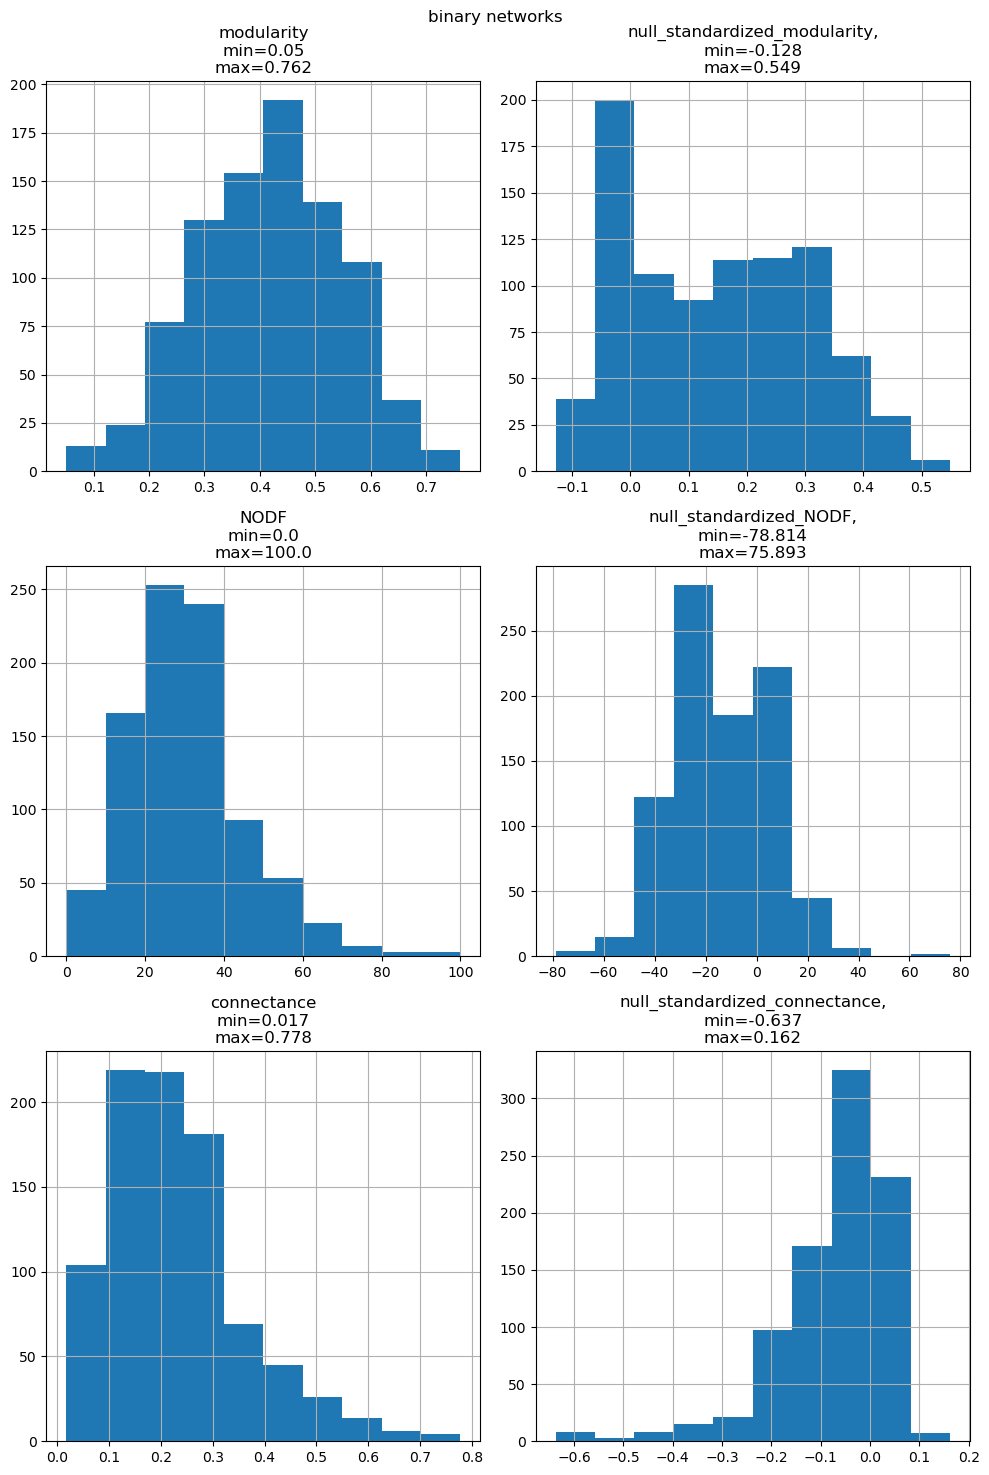

In [18]:
import matplotlib.pyplot as plt

features_to_examine = list(set(features_of_interest["network"])&set(alternative_features_df.columns))
print(f"features = {features_to_examine}")

relevant_features = alternative_features_df.loc[alternative_features_df.network_type.str.startswith("binar")]
fig, axes = plt.subplots(nrows=len(features_to_examine), ncols=2, figsize=(10, 5*len(features_to_examine)))
fig.suptitle(f"binary networks")
for i in range(len(features_to_examine)):
    f = features_to_examine[i]
    relevant_features[f].hist(ax=axes[i][0])
    axes[i][0].set_title(f"{f}\nmin={np.round(relevant_features[f].min(),3)}\nmax={np.round(relevant_features[f].max(),3)}")
    if f"null_standardized_{f}" in relevant_features.columns:
        relevant_features[f"null_standardized_{f}"].hist(ax=axes[i][1])
        axes[i][1].set_title(f"null_standardized_{f},\nmin={np.round(relevant_features[f'null_standardized_{f}'].min(),3)}\nmax={np.round(relevant_features[f'null_standardized_{f}'].max(),3)}")
fig.tight_layout()
fig.savefig(f"{network_features_dir}/binary_networks_based_feature_distribution.jpeg")

features = ['modularity', 'NODF', 'connectance']


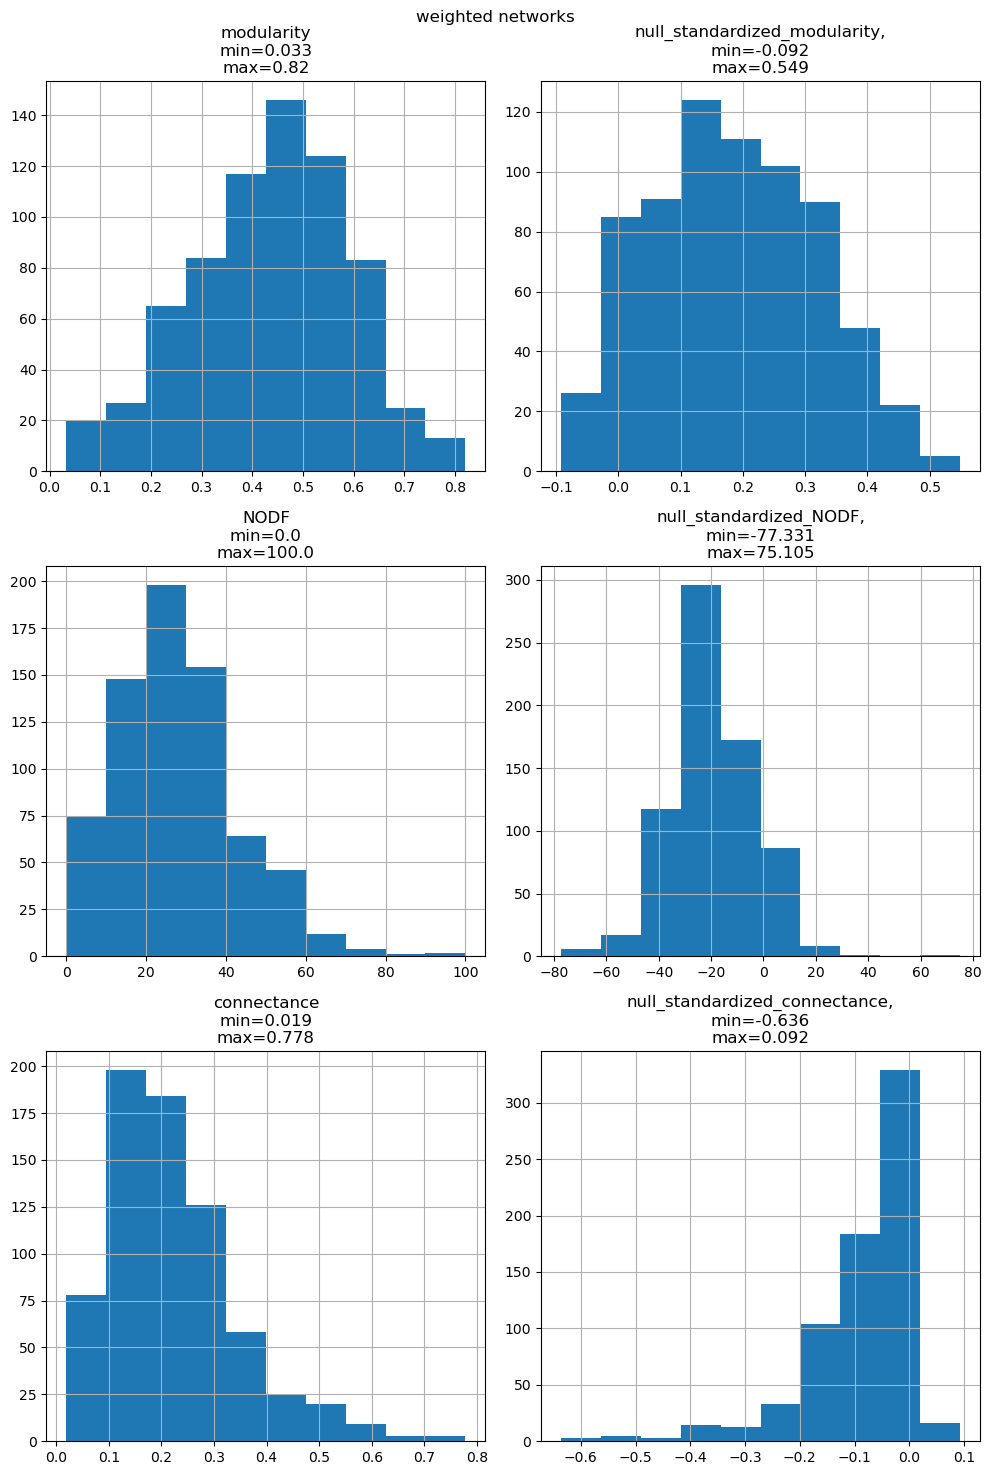

In [19]:
import matplotlib.pyplot as plt

features_to_examine = list(set(features_of_interest["network"])&set(alternative_features_df.columns))
print(f"features = {features_to_examine}")

relevant_features = alternative_features_df.loc[alternative_features_df.network_type.str.startswith("weighted")]
fig, axes = plt.subplots(nrows=len(features_to_examine), ncols=2, figsize=(10, 5*len(features_to_examine)))
fig.suptitle(f"weighted networks")
for i in range(len(features_to_examine)):
    f = features_to_examine[i]
    relevant_features[f].hist(ax=axes[i][0])
    axes[i][0].set_title(f"{f}\nmin={np.round(relevant_features[f].min(),3)}\nmax={np.round(relevant_features[f].max(),3)}")
    if f"null_standardized_{f}" in relevant_features.columns:
        relevant_features[f"null_standardized_{f}"].hist(ax=axes[i][1])
        axes[i][1].set_title(f"null_standardized_{f},\nmin={np.round(relevant_features[f'null_standardized_{f}'].min(),3)}\nmax={np.round(relevant_features[f'null_standardized_{f}'].max(),3)}")
fig.tight_layout()
fig.savefig(f"{network_features_dir}/weighted_networks_based_feature_distribution.jpeg")